# Feed Forward Neural Networks reducing data with principal component analysis

## Theoretical overview

In this notebook I will try a different method, i.e. feed forward neural networks, to address the classification problem related to the gravity spy dataset.

Neural networks are a class of machine learning algorithms which take inspiration from the structure of a biological brain.
The building blocks of these models, i.e. the artificial neurons, process data taking a vector of inputs $\mathbf{x}$ and returning an output value $y$ computed as
$$
    y = f(\mathbf{w}^T \mathbf{x} + b)
$$
where $\mathbf w$ and $b$ are the model's parameters optimized during the training process while $f$, called activation function, is chosen during the model definition. Some common choices for it will be discussed in the next section.

Neural networks are thus built connecting more of this artificial neurons together. The way in which these connections are made defines the specific class of neural network used.

Feedforward neural networks exhibit a structure similar to the one in the following picture:

<center>
<img src="./images/ffnn.png" width="50%">
</center>

artificial neurons are organized in layers which take input values only from neurons of the previous layer and propagate their outputs only to the ones of the following, thus the name feedforward.
The first and last layers are sometimes called, respectively, input and output layers while the ones in the middle are called hidden layers.

Universal approximation theorems, in their different formulations, grant the possibiility to approximate arbitrarily well any continuos function from the input to the output spaces with a sufficiently complex model. See Géron (2019) for further details.

Neural networks are essentially parametric functions whose parameters are optimized to obtain correct predictions on the data available in the training dataset. The performance of the model is evaluated by the loss function which is minimized during the training.
For classification problems the categorical cross entropy might be used as the loss function. It descend from the application of maximum likelihood estimation (Murphy, 2012, p. 571) and has the following form:

$$
C = -\sum_i \mathbf{y}_i \text{log}(\mathbf{\hat y}_i)
$$

where $\mathbf{y}_i$ and $\mathbf{\hat y}_i$ are respectively the true and predicted labels expressed as index vectors: vectors whose $j^{\text{th}}$ component is a float value indicating the probability for the $i^{\text{th}}$ element to belong to the $j^{\text{th}}$ class.

## Hyperparameters

There are several hyperparameters characterizing a neural network model. In this section I am going to make a quick review explaining also the choices made for the models used in this notebook.

### Activation function
The activation function is the non linear element of each neuron which maps the weighted sum of inputs to the neuron's output. Traditionally, the first activation function proposed was the Heaviside theta function which simulates the behaviour of a biological neuron, sending a signal to the connected units only when activated with inputs above a certain threshold.
The main problem of this function is that it is not differentiable in 0 creating problems during the backpropagation of the gradient. For this reason, it can be substituted by the sigmoid $\sigma(z)$

$$
    \sigma(z) = \frac{e^z}{1+e^z}
$$

which can simulate the same behaviour but with a smooth transition from 0 to 1.

Sometimes the sigmoid can be substituted by tanh$(z)$ whose saturating limits are -1 and 1 instead.

The problem of these activation functions is that they are saturating when their input value $z$ moves away from 0. In these limits the derivative falls quickly to zero leading to vanishing gradients that can slow down significatively the training process (Géron, 2019, pp. 373-376).

For this reason, a class of non-saturating activation functions were introduced.
The rectified linear unit (ReLU), defined as 

$$
    \text{ReLU}(z) = \text{max}(0,z)
$$

was proven to perform better compared to the previously cited functions.
However, it is still saturating for negative values of z where the derivative is also exactly 0. It was verified (Agarap 2018, Lu 2019) that during the training process about half of the ReLU neurons tend to die returning always 0, a problem known as the dying ReLU. This happens because the weighted sum of their inputs becomes negative and the null gradient of the ReLU function makes it difficult to escape this situation.

The leaky ReLU and the ELU were designed to solve this problem. Their definition is the following:

$$
    \text{Leaky ReLU} = \text{max}(0,z) + \text{min}(\alpha z, 0) \\
    \text{ELU} = \text{max}(0,z) + \text{min}(\alpha (e^z-1), 0) \\
$$

The leaky ReLU has the downside of not being differentiable in 0 in contrast to the ELU which for this reason usually performs better. The latter, however, requires more time to be computed due to the exponential function, making it not suitable for situation that require fast responses from the networks such as real time applications.

In the models trained in this project, the activation function used in the output layer is the `softmax` which is defined, for the $j^{\text{th}}$ neuron (on a total of K) as

$$
\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}
$$

in order to obtain values, from the K output neurons, which sum to 1 and can thus represent a discrete probability distribution.

### Network architecture
During the definition of the neural network model, the number of layers and the number of neurons in each of these layers need to be defined.

These hyperparameters define the overall complexity of the model since the addition of neurons or layers increases the number of connections and thus parameters. More complex models allow better approximations of the target function but slow down the training and increase the risk of overfitting the training data.

A fine tuning of the network's architecture is thus needed. In this notebook I have tried 5 different models varying the number of hidden layers and the number of neurons in them.

### Optimizer and related hyperparameters
The training process consists in searching the set of parameters for the neural network that minimize the cost function evaluated on the training dataset. This work is carried out with specific algorithms called optimizers. 
There are several choices available (see Géron, 2019), most of them rely on the gradient descent method which is then modified in order to correct some of the problems that usually arise.

Gradient descent is an iterative algorithm that at each step, starting from a point in the parameter's space, set the new parameters following the direction of the gradient which is the direction of steepest descent. 

The models used in this notebook were trained using the optimizer Adam, which stands for Adaptive Momentum (Kingma, 2014).
This algorithm works computing at each step the following quantities, where the index n indicates the iteration while the index j refers to a specific parameter
$$
    m_n^j = \beta_1 m_{n-1}^j + (1-\beta_1) \left[ \frac{\partial C}{\partial \theta^j} \right]_{\theta_n} \\
     s_n^j = \beta_2 s_{n-1}^j + (1-\beta_2) \left| \frac{\partial C}{\partial \theta^j} \right|^2_{\theta_n} \\
     m_n^j = \frac{m_n^j}{1+\beta_1^n} \\
     s_n^j = \frac{s_n^j}{1+\beta_2^n}  \\
$$
and then updating the parameters according to 
$$
    \theta^j_{n+1} = \theta^j_{n} - \frac{\eta_0}{\sqrt{s_n^j + \epsilon}}\cdot m_n^j
$$
This optimizer combines different strategies which help to obtain a faster and smoother convergence to the minimum of the cost function. It uses the momentum term which provides inertia that accelerates the process and reduces the effects of gradient irregularities and of its stochastic computation. Furthermore, it also implements an automatic regulation of the learning rate $\eta$ different for each component of the gradient and defined so that smaller learning rates get assigned to the directions with larger gradients, slowing down the descent in those directions.

In the code below I have used the deafult values for all of the hyperparameters that characterize this algorithm which are (Adam — keras documentation, n.d.):

$$
    \eta_0 = 0.001 \\
    \beta_1 = 0.9 \\
    \beta_2 = 0.999 \\
    \epsilon = 1e-7 \\
$$

Some tests with different optimizers and parameters provided similar or worse results.

## Data reduction

In this notebook I will use feedforward neural networks flattening the images in an input vector which is then provided to the input layer.

The images of the dataset studied are matrices of dimensions 71x60x3 = 12780 which is thus the number of dimensions of the features' space. 
This large number of inputs leads inevitably to complex models, i.e. with a huge number of parameters, which are harder to train requiring more time and being more incline to overfitting the data.
Furthermore, these features are expected to be highly correlated, for example neighboring pixels are more likely to have similar values.

For these reasons I used a specific method of data reduction called Principal Component Analysis (PCA).

The steps required to reduce the features' space dimensions from $P$ to $p$ mapping the $\mathbf x_i \in \mathbb{R}^P$ points to $\mathbf z_i \in \mathbb{R}^p$ are (Géron 2019, Murphy 2012):

1. center the design matrix subtracting the mean value of each feature computed over the training set, obtaining the matrix $\mathbf X$ 

2. apply singular value decomposition to $\mathbf X$ obtaining $\mathbf X = \mathbf{UXV^T}$ 

3. select the first $p$ column vectors $\mathbf v_l$ of the matrix V corresponding to the $p$ larger singular values 

4. map each vector $\mathbf x_i \in \mathbb{R}^P$ to $\mathbf z_i \in \mathbb{R}^p$ where $\mathbf z_i^T = (\mathbf x_i^T \mathbf v_1 \hspace{7pt} \mathbf x_i^T \mathbf v_2 \hspace{7pt} \cdot\cdot\cdot \hspace{7pt} \mathbf x_i^T \mathbf v_p)$ 

This algorithm consists essentially in projecting the data points in $\mathbb R^P$ to an hyperplane of $p$ dimensions maximizing the variance of the data preserved. It is derived requiring the minimization of the reconstruction error which is defined as $\sum_i ||\mathbf x_i -  \hat{\mathbf x}_i||^2$, where $\hat {\mathbf x}_i \equiv \sum_l z_i^l \mathbf v_l$ are the vectors reconstructed in the original features' space.

In the following code I have used the PCA implementation in scikitlearn selecting $p$ automatically in order to satisfy the request of mantaining the 95% of the dataset variance.

In [47]:
import my_utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [46]:
#importing the training set
x_train, y_train, df_data = u.get_images(u.train_files)
#reshape the matrices in one dimensional vectors
x_train = np.reshape(x_train, newshape=(x_train.shape[0], -1))
#rescaling the integers to float in the range [0,1]
x_train = x_train/256
#centering the design matrix in order to have mean 0 as required by PCA
x_train_mean = x_train.mean(axis=0)
x_train_centered = x_train - x_train_mean

100%|█████████████████████████████████████| 22348/22348 [00:21<00:00, 1030.90it/s]


In [3]:
#printing shape of the design matrix
np.shape(x_train_centered)

(22348, 12780)

In [7]:
#PCA using sikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
#passing x_train to pca.fit beacuse it automatically
#centers the matrix memorizing the mean in order
#to transform in the same way new data (ex. the test set)
x_train_red = pca.fit_transform(x_train)

Text(0, 0.5, 'Cumulative explained variance')

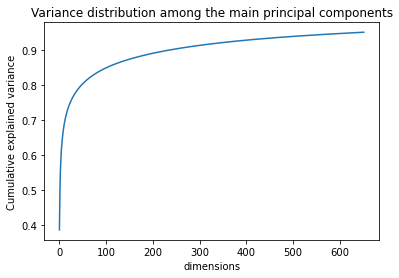

In [16]:
#plotting the variance distribution among pricnipal components
from matplotlib import pyplot as plt
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Variance distribution among the main principal components')
plt.xlabel('dimensions')
plt.ylabel('Cumulative explained variance')

This plot shows how the dataset variance is distributed among the first $p$ principal components. Requiring to keep the 95% of the original variance, the features space was reduced from 12780 dimensions to 652.
It is a significant reduction which will strongly affect the performances of the training.

In [10]:
import pickle
#saving the reduced dataset and the pca object for future use
with open(f"red_dataset.db", 'wb') as fmod:
        pickle.dump(x_train_red, fmod)
with open(f"pca.db", 'wb') as fmod:
    pickle.dump(pca, fmod)

In [15]:
np.shape(x_train_red)

(22348, 652)

## Training 

In [53]:
import pickle

In [54]:
#retrieving training set reduced with pca 
with open(f"red_dataset.db", 'rb') as fmod:
        x_train_red = pickle.load(fmod)

#retrieving pca object used to reduce the test set
with open(f"pca.db", 'rb') as fmod:
        pca = pickle.load(fmod)

In [55]:
#importing test set which will be used during training
x_test, y_test, df_test_data = u.get_images(u.test_files)
x_test = np.reshape(x_test, newshape=(x_test.shape[0], -1))
x_test = x_test/256

#apply pca transformation to test set
x_test_red = pca.transform(x_test)

100%|████████████████████████████████████████| 4720/4720 [00:07<00:00, 636.54it/s]


In [56]:
#converting labels to index vectors
y_train_mrx = np.array([[int(i==y) for i in range(0,22)] for y in y_train])
y_test_mrx = np.array([[int(i==y) for i in range(0,22)] for y in y_test])

In the following cells I implemented manually a grid search over some activation functions and some architectures with two layers and a different number of neurons for each of them.
At first attempt I tried using complex models with a large number of neurons and different numbers of layers. In this first part I also fixed the number of iteration of the training process to 200 epochs.
The next figure shows the trend of the loss function, computed for the training and for the test set, during the training.

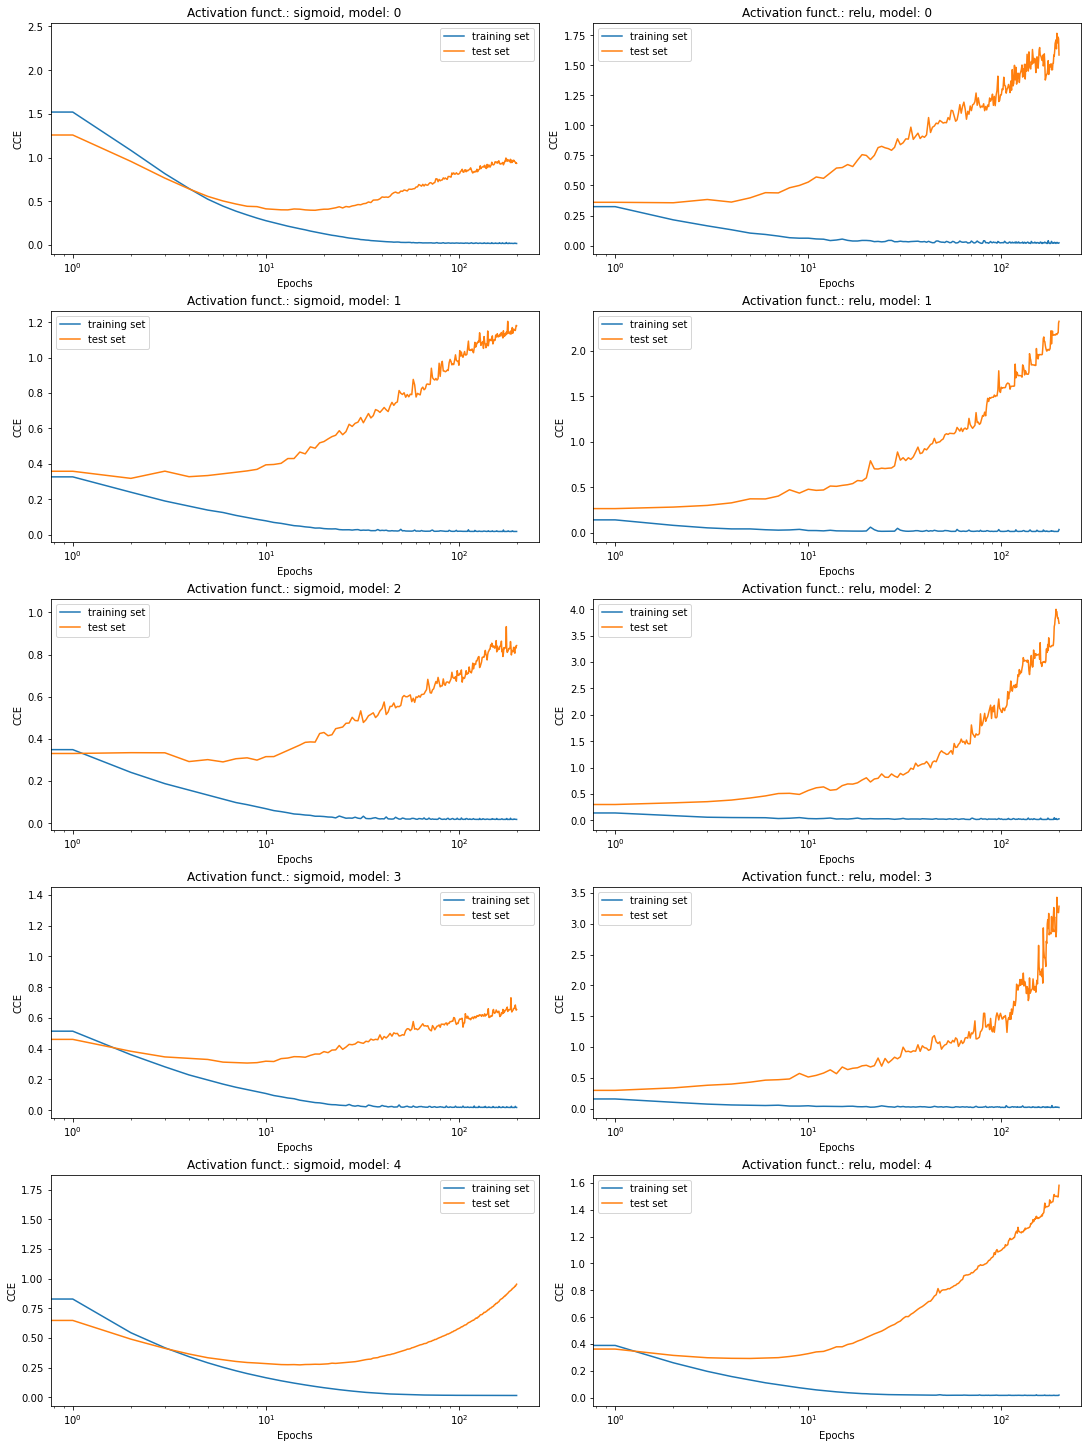

In [15]:
#plot cross entropy minimization during training
fig, axs = plt.subplots(len(old_deep_layers_totry),len(act_totry)-1, figsize=(15, 20), constrained_layout=True)
old_deep_layers_totry = [[32,32,32,32], [1024], [512,256], [512,128,64], [32]]

for j, act_f in enumerate(act_totry[:2]):
    for ia in range(0, len(deep_layers_totry)):
        with open(f"ffnn.Adam.{act_f}.{ia}/history.hist", 'rb') as hist:
            history = pickle.load(hist)
        axs[ia][j].plot(history['loss'], label='training set')
        axs[ia][j].plot(history['val_loss'], label='test set')
        axs[ia][j].set_xscale('log')
        axs[ia][j].set_xlabel('Epochs')
        axs[ia][j].set_ylabel('CCE')
        axs[ia][j].set_title(f"Activation funct.: {act_f}, model: {ia}")
        axs[ia][j].legend()

From this first test I have drawn two conclusions: all the models overfitted after about 10 epochs which is showed by the increment of the loss function on the test set. Furthermore, the simpler model with just one layer of 32 neurons provided, looking at the minimum of the test loss, a similar (or even better) result than the one provided by the more complex ones. 

Keeping into account these observations I runned a new grid search with simpler models of only two layers with fewer neurons. I also used the early stopping callback to stop the training when the loss function computed on the test set stops improving. Actually the training is not stopped immediately but after 15 iterations without improvements (set by the `patience` parameter) to avoid stopping in local minimums.

I have also tried using a `Dropout()` layer which, however, did not show any improvement. The results obtained are thus not shown.

In [57]:
#defining hyperparameters that will be tried with a grid search
act_totry = ['sigmoid', 'relu', 'elu']
deep_layers_totry = [ [8,8], [16,16], [32,32], [8,16], [32,16]]

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from tensorflow import keras
import os
from timeit import default_timer as timer

#starting grid search
for i_f, activation_function in enumerate(act_totry):
    for i_a, architecture in enumerate(deep_layers_totry):
        
        #define a model name
        model_name = f"ffnn5.Adam.{activation_function}.{i_f}.{i_a}.model"

        #defining model
        model = Sequential()
        model.add(InputLayer(input_shape=x_train_red.shape[1:]))
        for n_neurons in architecture:
            model.add(Dense(n_neurons, activation=activation_function))
        model.add(Dense(22, activation='softmax'))

        #compiling model with Adam optimizer
        model.compile(keras.optimizers.Adam(), loss='categorical_crossentropy')

        print(f"Model {model_name} prepared. Architecture:")
        model.summary()

        #preparing callback for early stopping
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        
        #starting timer
        tstart = timer()
        
        print("Starting to fit model")
        history = model.fit(x=x_train_red, y=y_train_mrx, epochs=200, verbose=True, shuffle=True, validation_data=(x_test_red, y_test_mrx), callbacks=[es] )
    
        #stopping timer
        tstop = timer()
        
        saving_dir = f"ffnn5.Adam.{activation_function}.{i_f}.{i_a}"
        os.mkdir(saving_dir)
        
        print("fit completed, saving model")
        #save history
        with open(f"{saving_dir}/history.hist", 'wb') as file_h:
            pickle.dump(history.history, file_h)
            
        #save time
        with open(f"run_times_ffnn.txt", "a") as ftimes:
            ftimes.write(f"{saving_dir},\t{tstop-tstart}\n")
            
        #save model
        model.save(saving_dir)

Model ffnn5.Adam.sigmoid.0.0.model prepared. Architecture:
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 8)                 5224      
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_50 (Dense)             (None, 22)                198       
Total params: 5,494
Trainable params: 5,494
Non-trainable params: 0
_________________________________________________________________
Starting to fit model
Epoch 1/200
699/699 [==============================] - 3s 2ms/step - loss: 2.9280 - val_loss: 2.3432
Epoch 2/200
699/699 [==============================] - 1s 1ms/step - loss: 2.2012 - val_loss: 1.8241
Epoch 3/200
699/699 [==============================] - 1s 1ms/step - loss: 1.7629 - val_loss: 1.54

Epoch 00026: early stopping
fit completed, saving model
INFO:tensorflow:Assets written to: ffnn5.Adam.sigmoid.0.1/assets
Model ffnn5.Adam.sigmoid.0.2.model prepared. Architecture:
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                20896     
_________________________________________________________________
dense_55 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_56 (Dense)             (None, 22)                726       
Total params: 22,678
Trainable params: 22,678
Non-trainable params: 0
_________________________________________________________________
Starting to fit model
Epoch 1/200
699/699 [==============================] - 2s 2ms/step - loss: 2.5089 - val_loss: 1.3645
Epoch 2/200
699/699 [==============================] - 1s 1ms/step - loss: 1

699/699 [==============================] - 1s 1ms/step - loss: 0.4479 - val_loss: 0.4628
Epoch 7/200
699/699 [==============================] - 1s 1ms/step - loss: 0.3773 - val_loss: 0.4243
Epoch 8/200
699/699 [==============================] - 1s 1ms/step - loss: 0.3367 - val_loss: 0.4020
Epoch 9/200
699/699 [==============================] - 1s 1ms/step - loss: 0.3051 - val_loss: 0.3831
Epoch 10/200
699/699 [==============================] - 1s 1ms/step - loss: 0.2714 - val_loss: 0.3676
Epoch 11/200
699/699 [==============================] - 1s 1ms/step - loss: 0.2474 - val_loss: 0.3603
Epoch 12/200
699/699 [==============================] - 1s 1ms/step - loss: 0.2293 - val_loss: 0.3479
Epoch 13/200
699/699 [==============================] - 1s 1ms/step - loss: 0.2096 - val_loss: 0.3401
Epoch 14/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1921 - val_loss: 0.3411
Epoch 15/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1791 - val_loss: 0.3

Epoch 8/200
699/699 [==============================] - 1s 1ms/step - loss: 0.0704 - val_loss: 0.3413
Epoch 9/200
699/699 [==============================] - 1s 1ms/step - loss: 0.0612 - val_loss: 0.3598
Epoch 00009: early stopping
fit completed, saving model
INFO:tensorflow:Assets written to: ffnn5.Adam.relu.1.2/assets
Model ffnn5.Adam.relu.1.3.model prepared. Architecture:
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 8)                 5224      
_________________________________________________________________
dense_73 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_74 (Dense)             (None, 22)                374       
Total params: 5,742
Trainable params: 5,742
Non-trainable params: 0
_________________________________________________________________
Start

699/699 [==============================] - 1s 1ms/step - loss: 0.1814 - val_loss: 0.3320
Epoch 7/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1521 - val_loss: 0.3437
Epoch 8/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1368 - val_loss: 0.3504
Epoch 9/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1182 - val_loss: 0.3578
Epoch 10/200
699/699 [==============================] - 1s 1ms/step - loss: 0.1074 - val_loss: 0.3759
Epoch 11/200
699/699 [==============================] - 1s 1ms/step - loss: 0.0971 - val_loss: 0.3913
Epoch 00011: early stopping
fit completed, saving model
INFO:tensorflow:Assets written to: ffnn5.Adam.elu.2.1/assets
Model ffnn5.Adam.elu.2.2.model prepared. Architecture:
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                20896     
___________

## Results

In this section I will first show the curves of the loss function during the training for all of the models. 
Then I will computed the confusion matrices and all the metrics introduced in the previous notebook in order to compare these models.

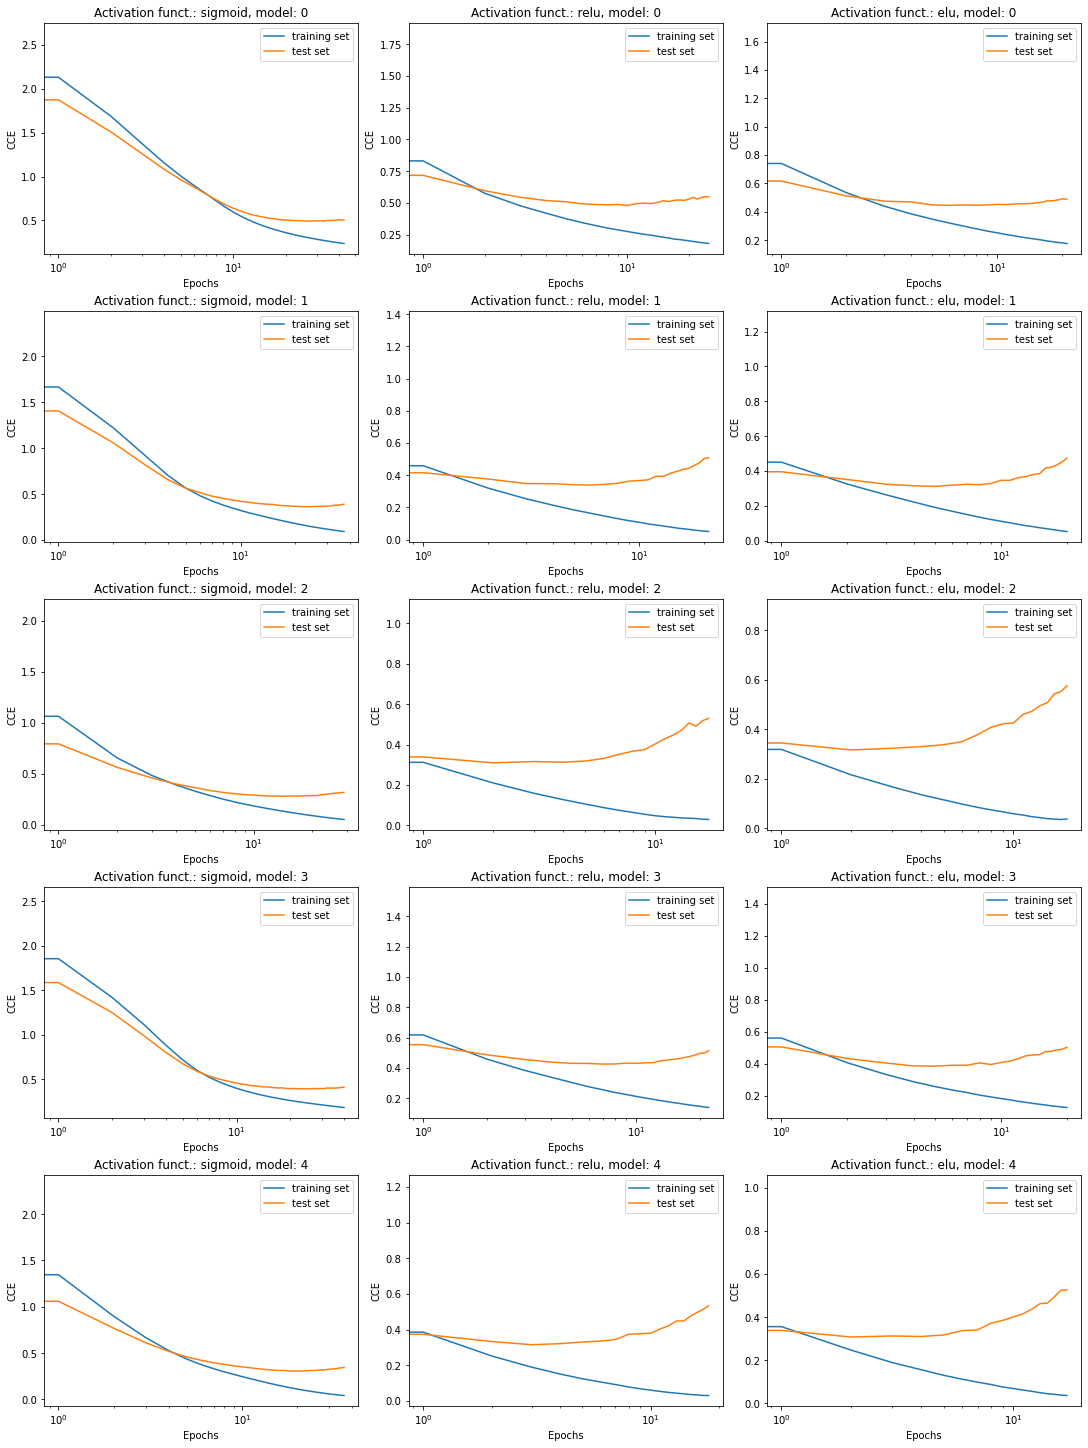

In [75]:
#plot cross entropy minimization during training
import pickle
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(deep_layers_totry),len(act_totry), figsize=(15, 20), constrained_layout=True)

for j, act_f in enumerate(act_totry):
    for ia in range(0, len(deep_layers_totry)):
        with open(f"ffnn4.Adam.{act_f}.{j}.{ia}/history.hist", 'rb') as hist:
            history = pickle.load(hist)
        axs[ia][j].plot(history['loss'], label='training set')
        axs[ia][j].plot(history['val_loss'], label='test set')
        axs[ia][j].set_xscale('log')
        axs[ia][j].set_xlabel('Epochs')
        axs[ia][j].set_ylabel('CCE')
        axs[ia][j].set_title(f"Activation funct.: {act_f}, model: {ia}")
        axs[ia][j].legend()
    

The figure above shows the trends of the loss function during the training of all of the models.
All of them reach similar values of the loss function and were all early stopped after about 20 to 30 epochs. 

The models implementing the sigmoid activation function required longer trainings and are observed to start from higher values of the loss function.
On the other end, the models with the ReLU and ELU activation functions provide the same loss function on the test set since their initialization and the rapidly overfit the data. For these models the `patience` parameter of early stopping set to 15 must be reduced. I runned again the training on these models with `patience=5`. The models obtained with this new training will be the ones compared in the following sections.

In [59]:
import my_utils as u
import numpy as np
import pickle
#loading test set
x_test, y_test, df_test_data = u.get_images(u.test_files)
x_test = np.reshape(x_test, newshape=(x_test.shape[0], -1))
x_test = x_test/256

#apply pca transformation to test set
from sklearn.decomposition import PCA
with open(f"pca.db", 'rb') as fmod:
        pca = pickle.load(fmod)
x_test_red = pca.transform(x_test)

100%|████████████████████████████████████████| 4720/4720 [00:06<00:00, 715.56it/s]


In [60]:
y_test_mrx = np.array([[int(i==y) for i in range(0,22)] for y in y_test])

In [68]:
from tensorflow import keras
import pandas as pd

#preparing pandas dataframe
results_df = pd.DataFrame()

#loading all the models in a dataframe
for j, act_f in enumerate(act_totry):
    for ia in range(0, len(deep_layers_totry)):
        model = f"ffnn5.Adam.{act_f}.{j}.{ia}"
        print(f'opening model {model}')
        kmod = keras.models.load_model(model)
        new_entry = {'model_name': model, 'activation': act_f, 'architecture': deep_layers_totry[ia], 'model_label': f'{act_f}, {deep_layers_totry[ia]}', 'model': kmod}
        results_df = results_df.append(new_entry, ignore_index=True)

opening model ffnn5.Adam.sigmoid.0.0
opening model ffnn5.Adam.sigmoid.0.1
opening model ffnn5.Adam.sigmoid.0.2
opening model ffnn5.Adam.sigmoid.0.3
opening model ffnn5.Adam.sigmoid.0.4
opening model ffnn5.Adam.relu.1.0
opening model ffnn5.Adam.relu.1.1
opening model ffnn5.Adam.relu.1.2
opening model ffnn5.Adam.relu.1.3
opening model ffnn5.Adam.relu.1.4
opening model ffnn5.Adam.elu.2.0
opening model ffnn5.Adam.elu.2.1
opening model ffnn5.Adam.elu.2.2
opening model ffnn5.Adam.elu.2.3
opening model ffnn5.Adam.elu.2.4


In [69]:
from tqdm import tqdm
tqdm.pandas()

#computing the predictions of each model on the test set
results_df['predicted_y_p'] = results_df['model'].progress_apply(lambda classif: classif.predict(x_test_red))
results_df['predicted_y'] = results_df['predicted_y_p'].progress_apply(lambda p: p.argmax(axis=1))

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 2983.57it/s]


In [70]:
from sklearn.metrics import confusion_matrix

#computing confusion matrix for each model
results_df['cmatrix'] = results_df['predicted_y'].progress_apply(lambda y_pred: confusion_matrix(y_test, y_pred))

#computing, for each model, the confusion matrix 
#with each element normalized with the number of elements 
#belonging to the same true class
results_df['cmatrix_truen'] = results_df['predicted_y'].progress_apply(lambda y_pred: confusion_matrix(y_test, y_pred, normalize='true'))

100%|████████████████████████████████████████████| 15/15 [00:00<00:00, 136.06it/s]


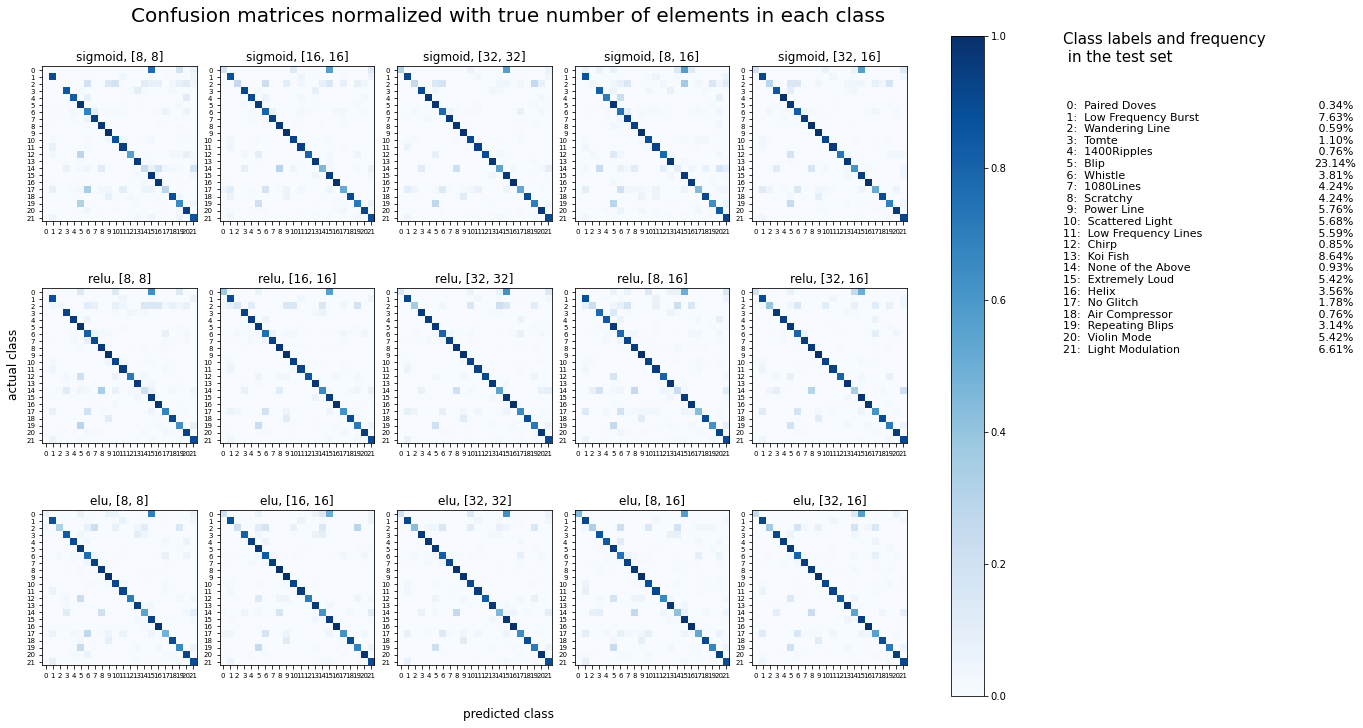

In [71]:
fig, axs = plt.subplots(len(act_totry), len(deep_layers_totry), figsize=(14, 10), constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
        cmat = results_df['cmatrix_truen'].iloc[i]
        im = ax.imshow(cmat, cmap='Blues')
        ax.set_title(f"{results_df.iloc[i]['model_label']}")
        ax.set_xticks(range(0,22))
        ax.set_yticks(range(0,22))
        ax.tick_params(axis='both', which='major', labelsize=7)

fig.suptitle('Confusion matrices normalized with true number of elements in each class', fontsize=20)
fig.supxlabel('predicted class')
fig.supylabel('actual class')
#cbar_ax = fig.add_axes( ax=axes.ravel().tolist())
fig.colorbar(im,  ax=axs.ravel().tolist())
fig.text(1.05, 0.92, "Class labels and frequency\n in the test set", fontsize=15)
#generate class legend
class_labels = u.get_class_labels()
class_labels['test_perc'] = class_labels['n_test']*100/class_labels['n_test'].sum()
classes=""
perc=""
for i, row in class_labels.iterrows():
    classes = classes + f"{row['class_id']:>2}:  {row['class'].replace('_', ' '):<25}\n"
    perc = perc + f"{row['test_perc']:>5.2f}%\n"

fig.text(1.05, 0.50, classes, fontsize=11)
fig.text(1.3, 0.50, perc, fontsize=11)
#empty print as a workaround to keep output clean
print()

The figure above shows the, more explanatory, normalized confusion matrices computed for each of the trained models.
Some observations can already be made from this fugure. All the models using the sigmoid activation function seem to show worse performances especilly with simpler models while the use of the elu activation function seems to provide the best results.
Furthermore, all of the models struggle in correctly classifying the elements of the 'Paired Doves' class which are instead usually classified as 'Extremely Loud'. This problem has been already encountered in the previous notebook where support vector machines were used.

I will now compute the metrics to provide a more detailed comparison.

In [72]:
#computing metrics

#Accuracy and  balanced accuracy
def compute_balacc(cmat):
    bacc = 0
    for i, row in enumerate(cmat):
        bacc += row[i]/row.sum()
    return bacc/len(cmat)
results_df['accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: cmat.trace()/cmat.sum())
results_df['balanced_accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_balacc(cmat))

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 5376.39it/s]


In [73]:
#F1-score and MCC
#F1 score
def compute_macroF1(cmat):
    mprec = 0
    mrec = 0
    #compute macro precision and macro recall
    for i in range(0, len(cmat)):
        mprec += (cmat[i][i]/(cmat[:,i].sum()+1e-20))
        mrec  += (cmat[i][i]/cmat[i].sum())
   
    mprec /= len(cmat)
    mrec  /= len(cmat)

    return 2*(mprec*mrec)/(mprec+mrec)

def compute_MCC(cmat):
    c = cmat.trace()
    s = cmat.sum()
    p = [cmat[:,k].sum()+1e-20 for k in range(0, len(cmat))]
    t = [cmat[k].sum() for k in range(0, len(cmat))]

    mcc = (c*s - np.dot(p,t))/np.sqrt((s**2-np.dot(p,p))*(s**2-np.dot(t,t)))
    return mcc

results_df['macroF1'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_macroF1(cmat))
results_df['MCC'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_MCC(cmat))

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 2142.72it/s]


In [78]:
results_df[['model_label', 'accuracy', 'balanced_accuracy', 'macroF1', 'MCC']].round(4)

,model_label,accuracy,balanced_accuracy,macroF1,MCC
0,"sigmoid, [8, 8]",0.8733,0.7228,0.7274,0.8599
1,"sigmoid, [16, 16]",0.9049,0.8026,0.8239,0.8949
2,"sigmoid, [32, 32]",0.9229,0.8288,0.8512,0.9147
3,"sigmoid, [8, 16]",0.8854,0.7363,0.7473,0.8732
4,"sigmoid, [32, 16]",0.9218,0.8202,0.8413,0.9135
5,"relu, [8, 8]",0.8951,0.7671,0.7718,0.8841
6,"relu, [16, 16]",0.9172,0.8291,0.8384,0.9085
7,"relu, [32, 32]",0.9239,0.8334,0.8581,0.9160
8,"relu, [8, 16]",0.8975,0.7650,0.7724,0.8867
9,"relu, [32, 16]",0.9214,0.8210,0.8369,0.9132


The different architectures trained exhibit very similar scores. The elu activation function did not provide any significant improvement. The model with the highest accuracy is the 7$^{\text{th}}$ and uses the ReLU activation function which is excellent because it is faster to compute than the others providing classifiers with better performance.

## Conclusions

The feed forward neural network that provided the best results was the 7$^{\text{th}}$ model which uses the ReLU activation function and is composed of two hidden layers of 32 neurons each.

From its application to the test set it obtained the following scores.

    Accuracy: 92.39%
    Balanced Accuracy: 83.34%
    F1-score: 85.81%
    MCC: 91.60%

## References

_Adam — keras documentation_, Available at: https://keras.io/api/optimizers/adam/

Agarap, Abien Fred. _Deep learning using rectified linear units (relu)._ arXiv preprint arXiv:1803.08375 (2018).

Géron, Aurélien. _Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems._ O'Reilly Media, 2019.

Kingma, Diederik P., and Jimmy Ba. _Adam: A method for stochastic optimization._ arXiv preprint arXiv:1412.6980 (2014).

Lu, Lu, et al. _Dying relu and initialization: Theory and numerical examples._ arXiv preprint arXiv:1903.06733 (2019).

Murphy, Kevin P. _Machine learning: a probabilistic perspective._ MIT press, 2012.